In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.4.0+cpu
2.4.0+cpu


In [4]:
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100701 sha256=c18142ff14b88e866077e94539f1c2321b410fe07f19e9fcb462b445c33c4095
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [6]:
from IPython.display import Audio
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.utils import download_asset

### 3. Construct the pipeline

In [7]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS

model = bundle.get_model()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

sample_rate = bundle.sample_rate

print(f"Sample rate: {sample_rate}")

100%|██████████| 319M/319M [00:02<00:00, 167MB/s]  
/opt/conda/lib/python3.10/site-packages/torchaudio/pipelines/_source_separation_pipeline.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Sample rate: 44100


#### 4. Configure the application functiond(path)
Sample rate: 44100
4. Configure the application function

In [8]:
from torchaudio.transforms import Fade


def separate_sources(
    model,
    mix,
    segment=10.0,
    overlap=0.1,
    device=None,
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap))
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape="linear")

    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model.forward(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out
        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0
    return final


def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    _, axis = plt.subplots(1, 1)
    axis.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=0, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.tight_layout()

### 5. Run Model

In [9]:
# We download the audio file from our storage. Feel free to download another file and use audio from a specific path
SAMPLE_SONG = download_asset("tutorial-assets/hdemucs_mix.wav")
waveform, sample_rate = torchaudio.load(SAMPLE_SONG)  # replace SAMPLE_SONG with desired path for different song
waveform = waveform.to(device)
mixture = waveform

# parameters
segment: int = 10
overlap = 0.1

print("Separating track")

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std()  # normalization

sources = separate_sources(
    model,
    waveform[None],
    device=device,
    segment=segment,
    overlap=overlap,
)[0]
sources = sources * ref.std() + ref.mean()

sources_list = model.sources
sources = list(sources)

audios = dict(zip(sources_list, sources))

100%|██████████| 28.8M/28.8M [00:00<00:00, 52.4MB/s]


Separating track


### 5.1 Separate Track

In [10]:
N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)

In [11]:
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str):
    print(
        "SDR score is:",
        separation.bss_eval_sources(original_source.detach().numpy(), predicted_source.detach().numpy())[0].mean(),
    )
    plot_spectrogram(stft(predicted_source)[0], f"Spectrogram - {source}")
    return Audio(predicted_source, rate=sample_rate)


segment_start = 150
segment_end = 155

frame_start = segment_start * sample_rate
frame_end = segment_end * sample_rate

drums_original = download_asset("tutorial-assets/hdemucs_drums_segment.wav")
bass_original = download_asset("tutorial-assets/hdemucs_bass_segment.wav")
vocals_original = download_asset("tutorial-assets/hdemucs_vocals_segment.wav")
other_original = download_asset("tutorial-assets/hdemucs_other_segment.wav")

drums_spec = audios["drums"][:, frame_start:frame_end].cpu()
drums, sample_rate = torchaudio.load(drums_original)

bass_spec = audios["bass"][:, frame_start:frame_end].cpu()
bass, sample_rate = torchaudio.load(bass_original)

vocals_spec = audios["vocals"][:, frame_start:frame_end].cpu()
vocals, sample_rate = torchaudio.load(vocals_original)

other_spec = audios["other"][:, frame_start:frame_end].cpu()
other, sample_rate = torchaudio.load(other_original)

mix_spec = mixture[:, frame_start:frame_end].cpu()

100%|██████████| 1.68M/1.68M [00:01<00:00, 944kB/s] 
100%|██████████| 1.68M/1.68M [00:00<00:00, 22.0MB/s]
100%|██████████| 1.68M/1.68M [00:00<00:00, 18.7MB/s]
100%|██████████| 1.68M/1.68M [00:00<00:00, 11.5MB/s]


### 5.3 Spectrograms and Audio

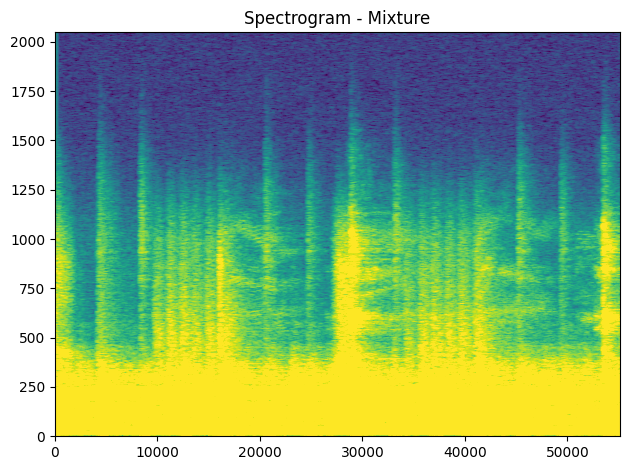

In [12]:
# Mixture Clip
plot_spectrogram(stft(mix_spec)[0], "Spectrogram - Mixture")
Audio(mix_spec, rate=sample_rate)

Drums SDR, Spectrogram, and Audio

SDR score is: 5.017735604564383


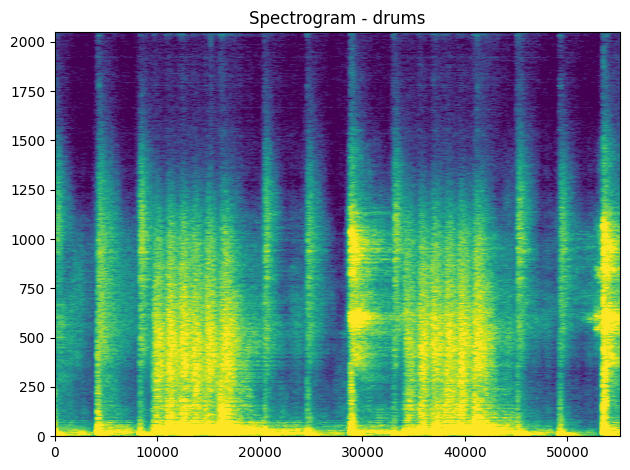

In [13]:
# Drums Clip
output_results(drums, drums_spec, "drums")

Bass SDR, Spectrogram, and Audio

SDR score is: 18.909251496228805


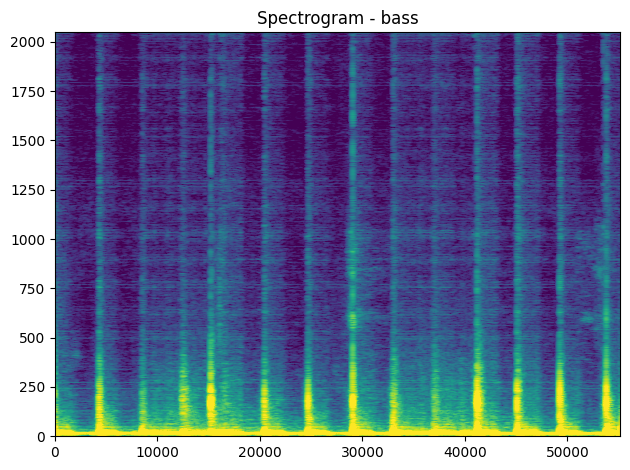

In [15]:
# Bass CBass SDR, Spectrogram, and Audiolip
output_results(bass, bass_spec, "bass")

Vocals SDR, Spectrogram, and Audio

SDR score is: 8.792411558756454


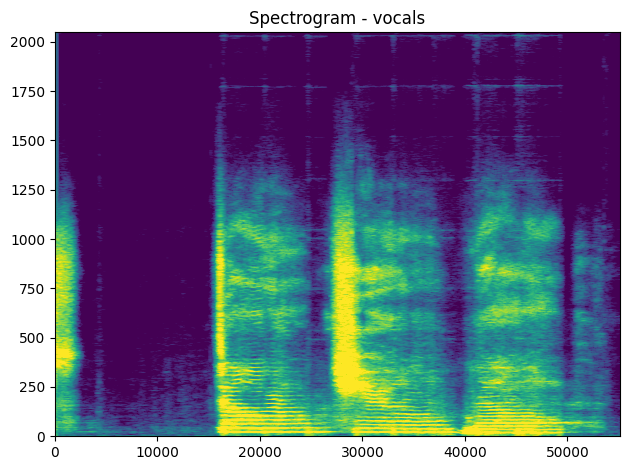

In [16]:
# Vocals Audio
output_results(vocals, vocals_spec, "vocals")

SDR score is: 8.86896723353766


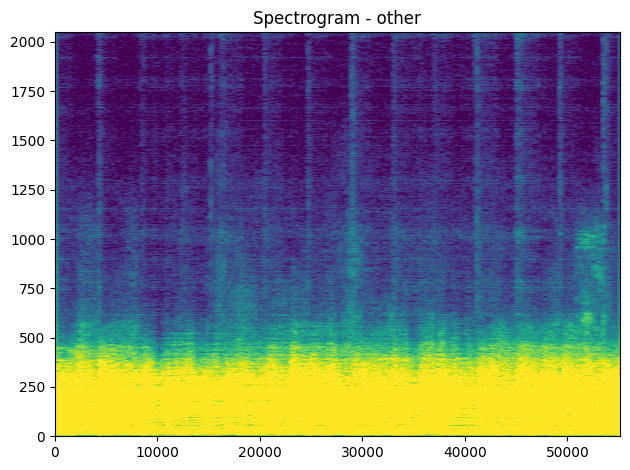

In [17]:
# Other Clip
output_results(other, other_spec, "other")